In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc
from scipy import stats

### 데이터 읽어오기

In [109]:
df = pd.read_excel("dataset_added.xlsx")

### 1. 수면 종합점수 sleep_score와 연관성이 가장 높은 항목 두 개를 추출하고, sleep_score를 설명하는 중요한 요인을 파악.

In [110]:
#sleep 관련 변수 필터링
sleep_cols = [col for col in df.columns if 'sleep_' in col.lower()]
sleep_data = df[sleep_cols]

In [ ]:
#sleep 관련 각각 col들과 'sleep_score'와의 pearson correlation 구하기
corr_score_for_each_var = sleep_data.corr(method='pearson', numeric_only=True)['sleep_score']

#pearson correlation이 가장 높은 두 개의 col 구하기
top2_highest_corr = corr_score_for_each_var.drop('sleep_score').abs().nlargest(2)
var1 = top2_highest_corr.index[0]
var2 = top2_highest_corr.index[1]

#방금 구한 두 개의 col과 sleep_score와의 pearson correlation의 신뢰성 검정하기
data_clean = df.dropna(axis=0, how='any', inplace=False)

for x in top2_highest_corr.index:
    var, pvalue_var = pearsonr(data_clean[x], data_clean['sleep_score'])
    print(f'{x}의 pearson correlation은 {round(var, 4)}이고, p-value는 {round(pvalue_var, 4)}입니다.')
    if (pvalue_var < 0.05):
        print(f'{x}은 sleep_score와 유의미하게 상관성이 있습니다.')
    else:
        print(f'{x}은 sleep_score와 유의미하게 상관성이 있다고 볼 수 없습니다.')
    print('\n')

### 1.2 sleep_cols들과 sleep_score의 상관성을 시각화: png로 저장

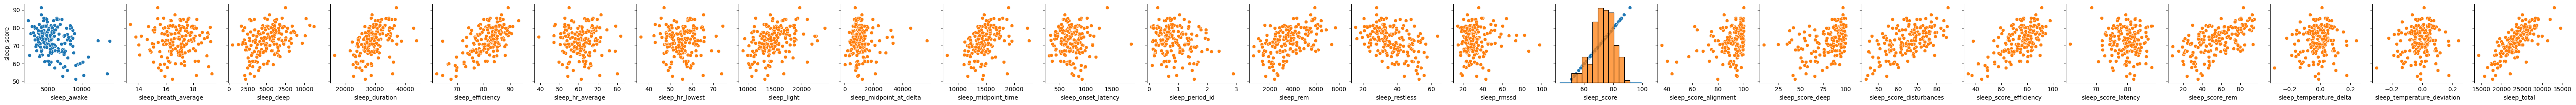

In [50]:
#sleep_cols들과 sleep_score의 상관성을 scatter plot으로 그린 결과
g = sns.pairplot(data=sleep_data, x_vars= sleep_cols, y_vars= ['sleep_score'], kind='scatter',diag_kind='kde', dropna=True)
g.map_upper(sns.scatterplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot)

plt.savefig('sleep_cols_and_sleep_score.png')

### 2. ANOVA: CN, MCI, Dem 그룹의 수면점수가 차이나는 지 검사
* H0: CN, MCI, Dem의 평균 수면 점수는 서로 동일하다 (치매 단계 간 수면 점수의 평균에 차이가 없다.)
* H1: CN, MCI, Dem 세 그룹 중 적어도 하나의 그룹의 수면 점수가 다른 그룹과 차이가 있다.
* alpha = 0.05

### ANOVA TABLE

In [51]:
sleep_score_fit = smf.ols("sleep_score~C(DIAG_NM, Sum)", data = df).fit()
table = sm.stats.anova_lm(sleep_score_fit)
print(table)

alpha = 0.05
p_value = table['PR(>F)'].iloc[0]
if (p_value > alpha):
    print("\nH0를 기각하지 않습니다.\n수면시간은 각 진단명에 따른 차이가 없다고 볼 수 있습니다.")
else:
    print("\nH0를 기각합니다.\n수면시간은 각 진단명에 따라 차이가 있습니다.")

                    df       sum_sq    mean_sq       F    PR(>F)
C(DIAG_NM, Sum)    2.0    36.865094  18.432547  0.3169  0.728831
Residual         171.0  9946.256147  58.165241     NaN       NaN

H0를 기각하지 않습니다.
수면시간은 각 진단명에 따른 차이가 없다고 볼 수 있습니다.


### Mulicomparison table

In [52]:
comp = mc.MultiComparison(df['sleep_score'], df['DIAG_NM'])
compatible,_,_ = comp.allpairtest(stats.ttest_ind, method = 'bonf')
compatible

group1,group2,stat,pval,pval_corr,reject
CN,Dem,0.4222,0.6736,1.0,False
CN,MCI,0.743,0.4586,1.0,False
Dem,MCI,-0.025,0.9801,1.0,False


### Pearson Correlation between sleep_score and TOTAL

The correlation coefficient is  0.0254
p value is 0.7395


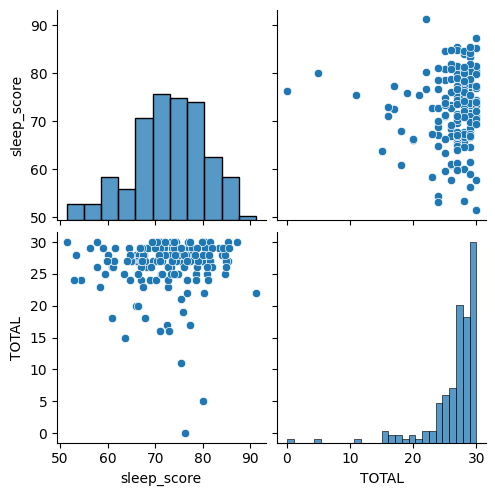

In [53]:
sns.pairplot(data = df, vars = ['sleep_score', 'TOTAL'], kind = 'scatter',dropna=True)

data_clean = df.dropna(axis = 0, how = 'any', inplace=False)
r2, p_value = pearsonr(data_clean['sleep_score'], data_clean['TOTAL'])

print('The correlation coefficient is ', np.round(r2, 4))
print('p value is', np.round(p_value, 4))

### ANOVA: DIAG_NM and TOTAL

In [54]:
total_fit = smf.ols("TOTAL~C(DIAG_NM, Sum)", data = df).fit()
table = sm.stats.anova_lm(total_fit)
print(table)

alpha = 0.05
p_value = table['PR(>F)'].iloc[0]
if (p_value > alpha):
    print("\nH0를 기각하지 않습니다.\n인지기능 총 점수는 각 진단명에 따른 차이가 없다고 볼 수 있습니다.")
else:
    print("\nH0를 기각합니다.\n인지기능 총 점수는 각 진단명에 따라 차이가 있습니다.")

                    df       sum_sq     mean_sq          F        PR(>F)
C(DIAG_NM, Sum)    2.0  1361.683529  680.841764  73.060969  1.164984e-23
Residual         171.0  1593.517621    9.318816        NaN           NaN

H0를 기각합니다.
인지기능 총 점수는 각 진단명에 따라 차이가 있습니다.


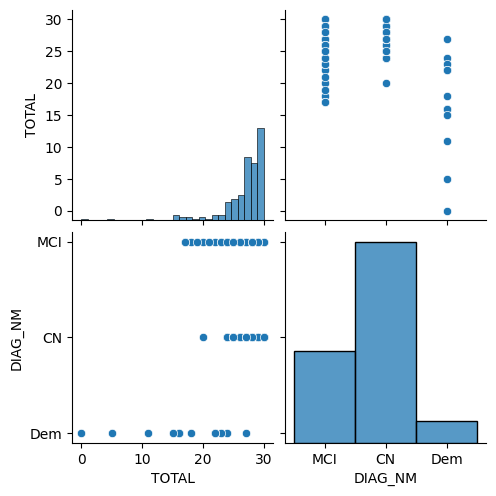

In [55]:
sns.pairplot(data = df, vars = ['TOTAL', 'DIAG_NM'], kind = 'scatter',dropna=True)

## OrderedLogstic regression: sleep factors & DIAG_NM

### Probit ordinal regression

In [120]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

new_dataframe = df[sleep_cols]

# 독립변수와 종속변수
X = sleep_data

df['DIAG_NM'] = pd.Categorical(df['DIAG_NM'], categories=['CN', 'MCI', 'Dem'], ordered=True)
y = df['DIAG_NM']

new_df = pd.concat([X, y], axis=1)
new_df

sleep_columns = X.columns

mod_prob = OrderedModel(new_df['DIAG_NM'],
                        new_df[sleep_columns],
                        distr='probit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

         Current function value: 0.718169
         Iterations: 22
         Function evaluations: 80
         Gradient evaluations: 68


/Users/raewookang/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/raewookang/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                DIAG_NM   Log-Likelihood:                -124.96
Model:                   OrderedModel   AIC:                             305.9
Method:            Maximum Likelihood   BIC:                             394.4
Date:                Sat, 23 Nov 2024                                         
Time:                        12:02:36                                         
No. Observations:                 174                                         
Df Residuals:                     146                                         
Df Model:                          26                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
sleep_awake                     0.0951      0.002     47.851      0.000       0.091       0.099
sleep_breath_average            0.1239      0.106      1.174      0.240      -0.083       0.331
sleep_deep                      0.0735      0.003     27.391      0.000       0.068       0.079
sleep_duration                 -0.0950      0.002    -47.843      0.000      -0.099      -0.091
sleep_efficiency               -0.0177      0.500     -0.035      0.972      -0.997       0.962
sleep_hr_average                0.0327      0.088      0.372      0.710      -0.140       0.205
sleep_hr_lowest                -0.0583      0.101     -0.578      0.563      -0.256       0.140
sleep_light                     0.0737      0.003     27.622      0.000       0.068       0.079
sleep_midpoint_at_delta     -3.574e-06   2.02e-05     -0.177      0.859   -4.31e-05    3.59e-05
sleep_midpoint_time            -0.0004      0.000     -1.060      0.289      -0.001       0.000
sleep_onset_latency             0.0003      0.001      0.437      0.662      -0.001       0.001
sleep_period_id                -0.0773      0.218     -0.354      0.723      -0.505       0.350
sleep_rem                       0.0739      0.003     27.525      0.000       0.069       0.079
sleep_restless                  0.0359      0.030      1.210      0.226      -0.022       0.094
sleep_rmssd                    -0.0111      0.011     -1.052      0.293      -0.032       0.010
sleep_score                     0.0105      2.871      0.004      0.997      -5.616       5.637
sleep_score_alignment           0.0166      0.288      0.058      0.954      -0.547       0.581
sleep_score_deep               -0.0013      0.289     -0.005      0.996      -0.568       0.565
sleep_score_disturbances        0.0537      0.435      0.123      0.902      -0.799       0.907
sleep_score_efficiency         -0.0362      0.383     -0.095      0.925      -0.787       0.714
sleep_score_latency            -0.0530      0.290     -0.182      0.855      -0.622       0.516
sleep_score_rem                -0.0339      0.290     -0.117      0.907      -0.603       0.535
sleep_score_total              -0.0079      1.002     -0.008      0.994      -1.972       1.956
sleep_temperature_delta        -0.0152     48.315     -0.000      1.000     -94.710      94.680
sleep_temperature_deviation    -0.0152     48.272     -0.000      1.000     -94.626      94.596
sleep_total                     0.0216      0.005      4.762      0.000       0.013       0.031
CN/MCI                          0.3555     24.515      0.015      0.988     -47.693      48.404
MCI/Dem                         0.3659      0.131      2.783      0.005       0.108       0.624
===============================================================================================
"""

### Logit ordinal regression

In [121]:
mod_logit = OrderedModel(new_df['DIAG_NM'],
                        new_df[sleep_columns],
                        distr='logit')

res_logit = mod_logit.fit(method='bfgs', disp=False)
res_logit.summary()

/Users/raewookang/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                DIAG_NM   Log-Likelihood:                -126.13
Model:                   OrderedModel   AIC:                             308.3
Method:            Maximum Likelihood   BIC:                             396.7
Date:                Sat, 23 Nov 2024                                         
Time:                        12:08:40                                         
No. Observations:                 174                                         
Df Residuals:                     146                                         
Df Model:                          26                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
sleep_awake                     0.0973      0.008     12.651      0.000       0.082       0.112
sleep_breath_average            0.2248      0.203      1.106      0.269      -0.174       0.623
sleep_deep                      0.0741      0.011      6.856      0.000       0.053       0.095
sleep_duration                 -0.0970      0.008    -12.032      0.000      -0.113      -0.081
sleep_efficiency                0.0026      0.895      0.003      0.998      -1.751       1.756
sleep_hr_average                0.0674      0.153      0.440      0.660      -0.233       0.368
sleep_hr_lowest                -0.1161      0.177     -0.654      0.513      -0.464       0.232
sleep_light                     0.0744      0.011      6.926      0.000       0.053       0.095
sleep_midpoint_at_delta     -5.165e-06   3.64e-05     -0.142      0.887   -7.66e-05    6.63e-05
sleep_midpoint_time            -0.0007      0.001     -1.084      0.278      -0.002       0.001
sleep_onset_latency             0.0004      0.001      0.379      0.705      -0.002       0.002
sleep_period_id                -0.1204      0.378     -0.318      0.750      -0.862       0.621
sleep_rem                       0.0745      0.011      6.899      0.000       0.053       0.096
sleep_restless                  0.0545      0.052      1.053      0.292      -0.047       0.156
sleep_rmssd                    -0.0164      0.018     -0.922      0.356      -0.051       0.018
sleep_score                     0.0099      4.902      0.002      0.998      -9.598       9.618
sleep_score_alignment           0.0261      0.492      0.053      0.958      -0.937       0.989
sleep_score_deep               -0.0020      0.494     -0.004      0.997      -0.970       0.966
sleep_score_disturbances        0.0849      0.744      0.114      0.909      -1.374       1.544
sleep_score_efficiency         -0.0813      0.647     -0.126      0.900      -1.350       1.187
sleep_score_latency            -0.0927      0.497     -0.186      0.852      -1.067       0.881
sleep_score_rem                -0.0487      0.493     -0.099      0.921      -1.015       0.917
sleep_score_total              -0.0176      1.713     -0.010      0.992      -3.374       3.339
sleep_temperature_delta        -0.0298     72.394     -0.000      1.000    -141.919     141.860
sleep_temperature_deviation    -0.0298     72.464     -0.000      1.000    -142.057     141.997
sleep_total                     0.0233      0.019      1.238      0.216      -0.014       0.060
CN/MCI                          0.5693     44.577      0.013      0.990     -86.801      87.940
MCI/Dem                         0.8923      0.149      5.970      0.000       0.599       1.185
===============================================================================================
"""